In [1]:
import gym
import torch
import torch.nn as nn
import numpy as np
from scipy.special import softmax

In [2]:
class ValueNet(nn.Module):
    def __init__(self, input_dim, hidden, output_dim):
        super(ValueNet, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, output_dim),
        )
    
    def forward(self, x):
        return self.model(x)

In [42]:
class POLO(object):
    def __init__(self, K, T, lambda_, noise_mu, noise_sigma, U, u_init, memory_size, 
                 observation_space, action_space, state_space, net_hidden_layers, num_nets, gamma, 
                 state_samples, gradient_steps, noise_gaussian=True):
        self.memory_size = memory_size
        self.obs_mem = np.zeros((self.memory_size, observation_space))
        self.state_mem = np.zeros((self.memory_size, state_space))
        
        self.K = K  # N_SAMPLES
        self.T = T  # TIMESTEPS
        self.lambda_ = lambda_
        self.noise_mu = noise_mu
        self.noise_sigma = noise_sigma
        self.U = U
        self.u_init = u_init
        self.reward_total = np.zeros(shape=(self.K))
        self.gamma = gamma
        self.state_samples = state_samples
        self.gradient_steps = gradient_steps


        if noise_gaussian:
            self.noise = np.random.normal(loc=self.noise_mu, scale=self.noise_sigma, size=(self.K, self.T))
        else:
            self.noise = np.full(shape=(self.K, self.T), fill_value=0.9)
        
        self.num_nets = num_nets
        
        self._build_value_nets(observation_space, net_hidden_layers, action_space)

    
    def _build_value_nets(self, input_dim, hidden, output_dim):
        self.value_nets = []
        self.loss_funcs = []
        self.optimizers = []
        
        for i in range(self.num_nets):
            self.value_nets.append(ValueNet(input_dim, hidden, output_dim))
            self.loss_funcs.append(nn.MSELoss())
            self.optimizers.append(torch.optim.Adam(self.value_nets[-1].parameters(), lr=0.01))
            
        
    def get_aggregated_value(self, s):
        values = []
        for net in self.value_nets:
            values.append(net(torch.tensor(s, dtype=torch.float)).item())
            
        values = np.array(values)
        weights = softmax(values)
        weighted_values = values * weights

        return sum(weighted_values)
        
    def learn(self, env):
        init_state = env.env.state
        for _ in range(self.gradient_steps):
            idx = np.random.choice(np.min([self.memory_counter, self.memory_size]), size=self.state_samples, replace=False)

            sampled_states = self.state_mem[idx,:]

            sampled_obs = self.obs_mem[idx,:]



            targets = x = [None for i in range(self.num_nets)]


            for s_state, o in zip(sampled_states, sampled_obs):
                discount = 1
                total_reward = 0

                max_rewards = [float('-inf') for _ in range(self.num_nets)]

                for k in range(self.K):
                    env.env.state = s_state
                    for t in range(self.T):
                        perturbed_action_t = self.U[t] + self.noise[k, t]

                        s, reward, _, _ = env.step([perturbed_action_t])

                        total_reward += discount * reward
                        discount *= self.gamma

                    for i in range(self.num_nets):
                        net = self.value_nets[i]
                        reward_for_net = torch.tensor(total_reward, dtype=torch.float) + net(torch.tensor(s, dtype=torch.float))
                        if reward_for_net > max_rewards[i]:
                            max_rewards[i] = reward_for_net



                for i in range(self.num_nets):
                    net = self.value_nets[i]
                    loss_func = self.loss_funcs[i]
                    optimizer = self.optimizers[i]

                    target = max_rewards[i]

                    if targets[i] is None:
                        targets[i] = torch.tensor([[target]], dtype=torch.float)
                    else:
                        targets[i] = torch.cat((targets[i], torch.tensor([[target]], dtype=torch.float)))

        
            for i in range(self.num_nets):
                net = self.value_nets[i]
                loss_func = self.loss_funcs[i]
                optimizer = self.optimizers[i]

                optimizer.zero_grad()

                preds = net(torch.tensor(sampled_obs, dtype=torch.float))

                loss = loss_func(preds, targets[i])

                loss.backward()
                optimizer.step()
                
        env.env.state = init_state

    
    def _compute_total_reward(self, k, env):
        discount = 1
        for t in range(self.T):
            perturbed_action_t = self.U[t] + self.noise[k, t]
            s, reward, _, _ = env.step([perturbed_action_t])
            self.reward_total[k] += discount * reward
            discount *= self.gamma
#         self.reward_total[k] += discount * self.get_aggregated_value(s)
    
    def _ensure_non_zero(self, reward, beta, factor):
        return np.exp(-factor * (beta - reward))
    
    def choose_action(self, env):
        init = env.env.state
        for k in range(self.K):
            self._compute_total_reward(k, env)
            env.env.state = init
        
        beta = np.max(self.reward_total)  # maximize reward of all trajectories
        reward_total_non_zero = self._ensure_non_zero(reward=self.reward_total, beta=beta, factor=1/self.lambda_)

        eta = np.sum(reward_total_non_zero)
        omega = 1/eta * reward_total_non_zero

        self.U += [np.sum(omega * self.noise[:, t]) for t in range(self.T)]
        
        
        env.env.state = init
        action = self.U[0]
        
        self.U = np.roll(self.U, -1)  # shift all elements to the left
        self.U[-1] = self.u_init  #
        self.reward_total[:] = 0
        
        
        return action
    
    
    def store_state(self, obs, state):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.obs_mem[index] = np.array(obs)
        self.state_mem[index] = np.array(state)

        self.memory_counter += 1
    

In [ ]:
ENV_NAME = "Pendulum-v0"
TIMESTEPS = 15 # T
N_SAMPLES = 80  # K

env = gym.make(ENV_NAME)
ACTION_LOW = env.action_space.low[0]
ACTION_HIGH = env.action_space.high[0]

noise_mu = 0
noise_sigma = 0.3
lambda_ = 1

Z = 16

U = np.random.uniform(low=ACTION_LOW, high=ACTION_HIGH, size=TIMESTEPS)

s = env.reset()
env.env.state = [np.pi, 1]

polo = POLO(K=N_SAMPLES, T=TIMESTEPS, U=U, lambda_=lambda_, noise_mu=noise_mu, 
            noise_sigma=noise_sigma, u_init=0, memory_size=512, 
            observation_space=env.observation_space.shape[0], action_space=env.action_space.shape[0], 
            state_space=len(env.env.state),
            net_hidden_layers=16, num_nets=6, gamma=0.99, state_samples=8, gradient_steps=16, noise_gaussian=True)


env.render()
import time
time.sleep(1)
polo.store_state(s, env.env.state)

rewards = []
for t in range(500):
    a = polo.choose_action(env)
    s, r, _, _ = env.step([a])
    rewards.append(r)
    print("action taken: {:.2f} reward received: {:.2f}".format(a, r))
    env.render()
    polo.store_state(s, env.env.state)
    
#     if t != 0 and t % Z == 0:
#         polo.learn(env)


action taken: 0.11 reward received: -9.97
action taken: -0.24 reward received: -9.66
action taken: 1.88 reward received: -9.36
action taken: -0.27 reward received: -9.05
action taken: 1.17 reward received: -8.72
action taken: 1.21 reward received: -8.43
action taken: 1.02 reward received: -8.14
action taken: 1.98 reward received: -7.86
action taken: 0.05 reward received: -7.60
action taken: 0.86 reward received: -7.37
action taken: -0.42 reward received: -7.21
action taken: 1.16 reward received: -7.16
action taken: -1.31 reward received: -7.17
action taken: -1.21 reward received: -7.37
action taken: -1.69 reward received: -7.75
action taken: -0.54 reward received: -8.35
action taken: -0.74 reward received: -9.01
action taken: -0.83 reward received: -9.77
action taken: -0.84 reward received: -10.27
action taken: -0.88 reward received: -9.57
action taken: -0.92 reward received: -8.84
action taken: -0.98 reward received: -8.13
action taken: -1.04 reward received: -7.44
action taken: -1.09

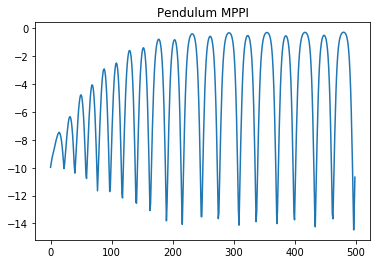

In [30]:
import matplotlib.pyplot as plt
plt.title("Pendulum MPPI")
plt.plot(range(len(rewards)), rewards)
plt.show()

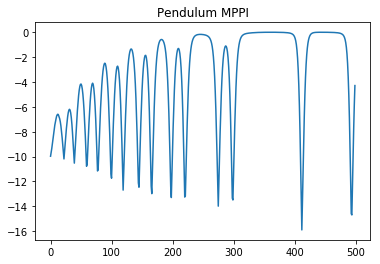

In [36]:
import matplotlib.pyplot as plt
plt.title("Pendulum MPPI")
plt.plot(range(len(rewards)), rewards)
plt.show()

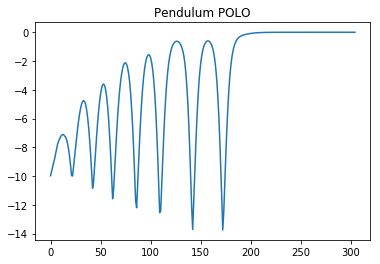

In [23]:
import matplotlib.pyplot as plt
plt.title("Pendulum POLO")
plt.plot(range(len(rewards)), rewards)
plt.show()

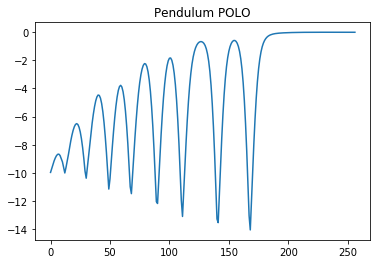

In [41]:
import matplotlib.pyplot as plt
plt.title("Pendulum POLO")
plt.plot(range(len(rewards)), rewards)
plt.show()

In [ ]:
ENV_NAME = "HumanoidStandup-v2"
TIMESTEPS = 14 # T
N_SAMPLES = 120  # K

env = gym.make(ENV_NAME)
ACTION_LOW = env.action_space.low[0]
ACTION_HIGH = env.action_space.high[0]

noise_mu = 0
noise_sigma = 0.3
lambda_ = 1

Z = 16

U = np.random.uniform(low=ACTION_LOW, high=ACTION_HIGH, size=TIMESTEPS)

s = env.reset()

polo = POLO(K=N_SAMPLES, T=TIMESTEPS, U=U, lambda_=lambda_, noise_mu=noise_mu, 
            noise_sigma=noise_sigma, u_init=0, memory_size=512, 
            observation_space=env.observation_space.shape[0], action_space=env.action_space.shape[0], 
            state_space=len(env.env.state),
            net_hidden_layers=16, num_nets=6, gamma=0.99, state_samples=8, gradient_steps=16, noise_gaussian=True)


env.render()
polo.store_state(s, env.env.state)

for t in range(10000):
    a = polo.choose_action(env)
    s, r, _, _ = env.step([a])
    print("action taken: {:.2f} reward received: {:.2f}".format(a, r))
    env.render()
    polo.store_state(s, env.env.state)
    
    if t != 0 and t % Z == 0:
        polo.learn(env)

In [6]:
import gym
import torch
import torch.nn as nn
import numpy as np
from scipy.special import softmax

In [7]:
ENV_NAME = "HumanoidStandup-v2"
env = gym.make(ENV_NAME)
s = env.reset()
env.render()


Creating window glfw


In [8]:
print(env.observation_space)
print(env.action_space)

Box(376,)
Box(17,)


In [9]:
action = np.random.uniform(low=-1, high=1, size=17)

In [10]:
import time
import copy

s = env.reset()
env.render()
init_state = env.sim.get_state()
for i in range(100):
    action = np.random.uniform(low=-1, high=1, size=17)
    _ = env.step(action)
    env.render()
    time.sleep(0.1)
time.sleep(3)
env.sim.set_state(init_state)
for i in range(100):
    action = np.random.uniform(low=-1, high=1, size=17)
    _ = env.step(action)
    env.render()
    time.sleep(0.1)
env.render()

KeyboardInterrupt: 

In [11]:
print(env.data)

In [4]:
class mppi(object):
    def __init__(self, K, T, lambda_, noise_mu, noise_sigma, U, u_init, memory_size, 
                 observation_space, action_space, state_space, net_hidden_layers, num_nets, gamma, 
                 state_samples, gradient_steps, noise_gaussian=True):
        self.memory_size = memory_size
        self.obs_mem = np.zeros((self.memory_size, observation_space))
        self.state_mem = np.zeros((self.memory_size, state_space))
        
        self.K = K  # N_SAMPLES
        self.T = T  # TIMESTEPS
        self.lambda_ = lambda_
        self.noise_mu = noise_mu
        self.noise_sigma = noise_sigma
        self.U = U
        self.u_init = u_init
        self.reward_total = np.zeros(shape=(self.K))
        self.gamma = gamma
        self.state_samples = state_samples
        self.gradient_steps = gradient_steps


        if noise_gaussian:
            self.noise = np.random.normal(loc=self.noise_mu, scale=self.noise_sigma, size=(self.K, self.T))
        else:
            self.noise = np.full(shape=(self.K, self.T), fill_value=0.9)
        
        self.num_nets = num_nets
        
#         self._build_value_nets(observation_space, net_hidden_layers, action_space)

    
    def _build_value_nets(self, input_dim, hidden, output_dim):
        self.value_nets = []
        self.loss_funcs = []
        self.optimizers = []
        
        for i in range(self.num_nets):
            self.value_nets.append(ValueNet(input_dim, hidden, output_dim))
            self.loss_funcs.append(nn.MSELoss())
            self.optimizers.append(torch.optim.Adam(self.value_nets[-1].parameters(), lr=0.01))
            
        
    def get_aggregated_value(self, s):
        values = []
        for net in self.value_nets:
            values.append(net(torch.tensor(s, dtype=torch.float)).item())
            
        values = np.array(values)
        weights = softmax(values)
        weighted_values = values * weights

        return sum(weighted_values)
        
    def learn(self, env):
        init_state = env.env.state
        for _ in range(self.gradient_steps):
            idx = np.random.choice(np.min([self.memory_counter, self.memory_size]), size=self.state_samples, replace=False)

            sampled_states = self.state_mem[idx,:]

            sampled_obs = self.obs_mem[idx,:]



            targets = x = [None for i in range(self.num_nets)]


            for s_state, o in zip(sampled_states, sampled_obs):
                discount = 1
                total_reward = 0

                max_rewards = [float('-inf') for _ in range(self.num_nets)]

                for k in range(self.K):
                    env.env.state = s_state
                    for t in range(self.T):
                        perturbed_action_t = self.U[t] + self.noise[k, t]

                        s, reward, _, _ = env.step([perturbed_action_t])

                        total_reward += discount * reward
                        discount *= self.gamma

                    for i in range(self.num_nets):
                        net = self.value_nets[i]
                        reward_for_net = torch.tensor(total_reward, dtype=torch.float) + net(torch.tensor(s, dtype=torch.float))
                        if reward_for_net > max_rewards[i]:
                            max_rewards[i] = reward_for_net



                for i in range(self.num_nets):
                    net = self.value_nets[i]
                    loss_func = self.loss_funcs[i]
                    optimizer = self.optimizers[i]

                    target = max_rewards[i]

                    if targets[i] is None:
                        targets[i] = torch.tensor([[target]], dtype=torch.float)
                    else:
                        targets[i] = torch.cat((targets[i], torch.tensor([[target]], dtype=torch.float)))

        
            for i in range(self.num_nets):
                net = self.value_nets[i]
                loss_func = self.loss_funcs[i]
                optimizer = self.optimizers[i]

                optimizer.zero_grad()

                preds = net(torch.tensor(sampled_obs, dtype=torch.float))

                loss = loss_func(preds, targets[i])

                loss.backward()
                optimizer.step()
                
        env.env.state = init_state

    
    def _compute_total_reward(self, k, env):
        discount = 1
        for t in range(self.T):
            perturbed_action_t = self.U[t] + self.noise[k, t]
            s, reward, _, _ = env.step([perturbed_action_t])
            self.reward_total[k] += discount * reward
            discount *= self.gamma
#         self.reward_total[k] += discount * self.get_aggregated_value(s)
    
    def _ensure_non_zero(self, reward, beta, factor):
        return np.exp(-factor * (beta - reward))
    
    def choose_action(self, env):
        init = env.env.state
        for k in range(self.K):
            self._compute_total_reward(k, env)
            env.env.state = init
        
        beta = np.max(self.reward_total)  # maximize reward of all trajectories
        reward_total_non_zero = self._ensure_non_zero(reward=self.reward_total, beta=beta, factor=1/self.lambda_)

        eta = np.sum(reward_total_non_zero)
        omega = 1/eta * reward_total_non_zero

        self.U += [np.sum(omega * self.noise[:, t]) for t in range(self.T)]
        
        
        env.env.state = init
        action = self.U[0]
        
        self.U = np.roll(self.U, -1)  # shift all elements to the left
        self.U[-1] = self.u_init  #
        self.reward_total[:] = 0
        
        
        return action
    
    
    def store_state(self, obs, state):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.obs_mem[index] = np.array(obs)
        self.state_mem[index] = np.array(state)

        self.memory_counter += 1
    